In [1]:
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
from config import IMAGE_TRANSFORM
import torch
import clip
import os
import math
from pytorchvideo import transforms as pv_transforms
from torchvision.transforms._transforms_video import NormalizeVideo
from pytorchvideo.data.clip_sampling import ConstantClipsPerVideoSampler
from pytorchvideo.data.encoded_video import EncodedVideo
import av

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Pl

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("cat.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = CLIP_model.encode_image(image)
    text_features = CLIP_model.encode_text(text)
    
    logits_per_image, logits_per_text = CLIP_model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
probs

array([[0.00569609, 0.00521164, 0.98909223]], dtype=float32)

In [156]:
image_features.shape, text_features.shape

(torch.Size([1, 512]), torch.Size([3, 512]))

In [4]:
def load_and_transform_vision_date(image_paths, device="cpu"):
    if image_paths is None: return None
    image_outputs = []

    for image_path in os.listdir(image_paths):
        if image_path.endswith(".jpg") or image_path.endswith(".jpeg") or image_path.endswith(".png"):
            with open(os.path.join(image_paths, image_path), "rb") as im:
                image = Image.open(im).convert("RGB")
                image = IMAGE_TRANSFORM(img = image)
                image_outputs.append(image)
    return torch.stack(image_outputs, dim=0)

images = load_and_transform_vision_date("Data/image_Data")
images.shape

torch.Size([2, 3, 224, 224])

In [5]:
def load_and_transform_text(texts, device="cpu"):
    if texts is None: return None
    tokens = [clip.tokenize(text).unsqueeze(0).to(device) for text in texts]
    return torch.cat(tokens, dim=0)
tokenized_text = load_and_transform_text(["cat", "dog"])
tokenized_text.shape

torch.Size([2, 1, 77])

In [6]:
def uniform_crop(images, size, spacial_idx, boxes=None, scale_size=None):
    assert spacial_idx in [0, 1, 2], "`spacial_idx` must be 0 -> Left | 1 -> Center | 2 -> Right"
    height = images.shape[2]
    width = images.shape[3]
    
    if scale_size: # Scale size keeps the ratio of original height and widht intact but changes the shorter size to `scale_size`
        if height <= width:
            width, height = int((width/height)*scale_size), scale_size
        else:
            width, height = scale_size, int((height/width)*scale_size)
        
        images = torch.nn.functional.interpolate(
            images,
            size=(height, width),
            mode = "bilinear",
            align_corners=False
        )
    y_offset = math.ceil((height-size)/2)
    x_offset = math.ceil((width-size)/2)

    if height <= width:
        if spacial_idx == 0:
            x_offset = 0
        elif spacial_idx == 2:
            x_offset = width - size
    else:
        if spacial_idx == 0:
            y_offset = 0
        elif spacial_idx == 2:
            y_offset = height - size

    return images[:, :, y_offset : y_offset + size, x_offset : x_offset + size]

images = torch.rand(3, 2, 1080, 1920)
cropped = uniform_crop(images, 224, spacial_idx=0)
cropped.shape

torch.Size([3, 2, 224, 224])

In [7]:
class Spacial_Crop(nn.Module):
    def __init__(self, crop_size: int, num_crops: int = 3):
        super().__init__()

        self.crop_size = crop_size
        if num_crops == 3:
            self.crop_directions = [0, 1, 2] # 0 -> Left | 1 -> Center | 2 -> Right
        elif num_crops == 1:
            self.crop_directions = [1] # 1 -> Center
        else:
            raise NotImplementedError("Make sure the `num_crops` is either 1 or 3, 3 being default")
    
    def forward(self, videos):
        res = []
        for video in videos:
            for spacial_idx in self.crop_directions:
                res.append(uniform_crop(video, size=self.crop_size, spacial_idx=spacial_idx))
        return torch.stack(res, dim=0)

In [10]:
def get_clip_timepoints(clip_sampler, duration):
    is_last_clip = False
    end = 0.9
    clip_time_points = []
    while not is_last_clip:
        start, end, _, _, is_last_clip = clip_sampler(0.0, duration, annotation=False)
        clip_time_points.append((start, end))
    return clip_time_points

def load_and_transform_video_data(video_paths, device, clip_duration=2, clips_per_video=5):
    video_outputs = []
    video_transform = transforms.Compose(
        [
            pv_transforms.ShortSideScale(224),
            NormalizeVideo(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )

    clip_sampler = ConstantClipsPerVideoSampler(
        clip_duration=clip_duration, clips_per_video=clips_per_video, 
    )

    frame_sampler = pv_transforms.UniformTemporalSubsample(num_samples=2)
    for video_path in os.listdir(video_paths): 
        if video_path.endswith(".mp4"):
            encoded_video = EncodedVideo.from_path(
                file_path=f"Data/Video_Data/{video_path}",
                decode_audio=False,
                decoder="pyav"
            )

            all_frames = []

            clip_time_points = get_clip_timepoints(clip_sampler=clip_sampler, duration=encoded_video.duration)

            for clip_time_point in clip_time_points:
                clip = encoded_video.get_clip(clip_time_point[0], clip_time_point[1])
                if clip is None: ValueError("No Clip Found") 
                frames = frame_sampler(clip["video"]) / 255.0

                all_frames.append(frames)
            all_videos = [video_transform(frame) for frame in all_frames]
            video_outputs.append(Spacial_Crop(crop_size = 224, num_crops = 3)(all_videos))
    return torch.stack(video_outputs, dim=0).to(device)
    
clips = load_and_transform_video_data("Data/Video_Data", device="cpu", clip_duration=2, clips_per_video=5)
clips.shape

torch.Size([2, 15, 3, 2, 224, 224])

In [148]:
video_outputs[0].shape

torch.Size([15, 3, 2, 224, 224])

In [115]:
all_frames[0][0].shape

torch.Size([2, 1080, 1920])

In [ ]:
video_transform(all_frames[0])

torch.Size([3, 2, 224, 398])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


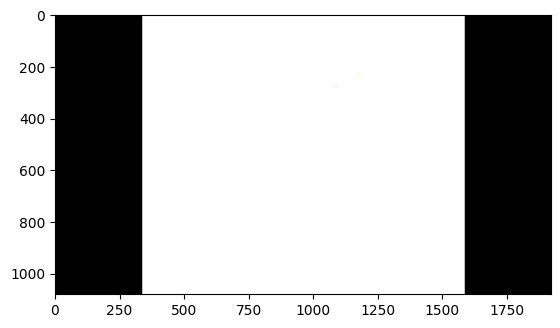

In [101]:
some_image = frame_sampler(encoded_video.get_clip(0, 2)["video"])#.shape
plt.imshow(some_image.permute(1,0,2,3)[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


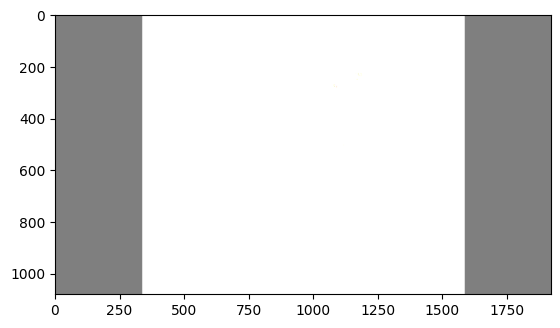

In [ ]:
plt.imshow(some_image.permute(1,0,2,3)[0].permute(1,2,0))

In [68]:
get_clip_timepoints(clip_sampler=clip_sampler, duration=encoded_video.duration)

[(Fraction(0, 1), Fraction(2, 1)),
 (Fraction(3, 5), Fraction(13, 5)),
 (Fraction(6, 5), Fraction(16, 5)),
 (Fraction(9, 5), Fraction(19, 5)),
 (Fraction(12, 5), Fraction(22, 5))]